## 0. 데이터 로드, 전처리

<데이터 목록>
- 서울특별시_광진구_도시공원정보_20250310.csv
- 행정동별_인구비율_데이터.csv (각 세대수에 거주하는 연령대 분포)

### 0.1 데이터 로드

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.font_manager as fm
import matplotlib as mpl

In [2]:
park_file = 'data/서울특별시_광진구_도시공원정보_20250310.csv'
park_data = pd.read_csv(park_file)
park_data.head(2)

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자
0,11215-10510,성화공원,어린이공원,NaN,서울특별시 광진구 자양동 199-4,37.536207,127.061859,253.0,NaN,조합놀이대,NaN,NaN,NaN,1979-09-15,서울특별시 광진구청,02-450-7775,2025-03-10
1,11215-10511,양마장공원,어린이공원,NaN,서울특별시 광진구 자양동 689-6,37.530871,127.088727,1113.0,NaN,"조합놀이대, 그네, 흔들놀이기구",NaN,NaN,NaN,1982-03-09,서울특별시 광진구청,02-450-7775,2025-03-10


In [3]:
age_file = 'data/행정동별_인구비율_데이터.csv'
age_data = pd.read_csv(age_file)
age_data.head(5)

,행정동,전체 인구수,전체세대,인구/세대_비율,0~4세,5~9세,10~14세,15~19세,20~24세,25~29세,...,55~59세,60~64세,65~69세,70~74세,75~79세,80~84세,85~89세,90~94세,95~99세,100세 이상
0,화양동,27754,18011,1.540947,0.009106,0.008995,0.011160,0.043529,0.364499,0.395980,...,0.054411,0.047804,0.044195,0.033202,0.027261,0.018156,0.010216,0.002665,0.000611,0.000111
1,군자동,21293,11223,1.897265,0.028335,0.035285,0.041165,0.053996,0.213936,0.291990,...,0.118774,0.126437,0.104785,0.069767,0.058184,0.043215,0.019959,0.005257,0.000980,0.000356
2,중곡1동,15587,8673,1.797187,0.030439,0.029517,0.037703,0.039894,0.102848,0.228410,...,0.142511,0.136054,0.117952,0.073446,0.060994,0.044737,0.020178,0.006803,0.001153,0.000115
3,중곡2동,20603,10548,1.953261,0.028631,0.046359,0.058684,0.059158,0.105328,0.208096,...,0.160789,0.160220,0.131873,0.089496,0.068070,0.044463,0.019056,0.005025,0.001517,0.000000
4,중곡3동,15723,8473,1.855659,0.032102,0.033990,0.041898,0.048625,0.091939,0.181754,...,0.159566,0.168417,0.138440,0.086038,0.076006,0.051222,0.022896,0.005311,0.001534,0.000000


### 0.2 데이터 전처리

In [4]:
import matplotlib.pyplot as plt

# 한글 폰트 설정
plt.rcParams['axes.unicode_minus'] = False

# 폰트 설정
plt.rcParams['font.family'] = 'AppleGothic'

광진구 행정동 수: 15
     ADM_NM    ADM_CD
1223   중곡4동  11050580
1242    광장동  11050630
1243   자양1동  11050640
1244   자양2동  11050650
1407    화양동  11050530
1408    군자동  11050540
1411   중곡1동  11050550
1413   중곡2동  11050560
1414   중곡3동  11050570
1415     능동  11050590
1428   구의1동  11050600
1429   구의3동  11050620
1441   자양3동  11050660
1448   자양4동  11050670
3124   구의2동  11050610


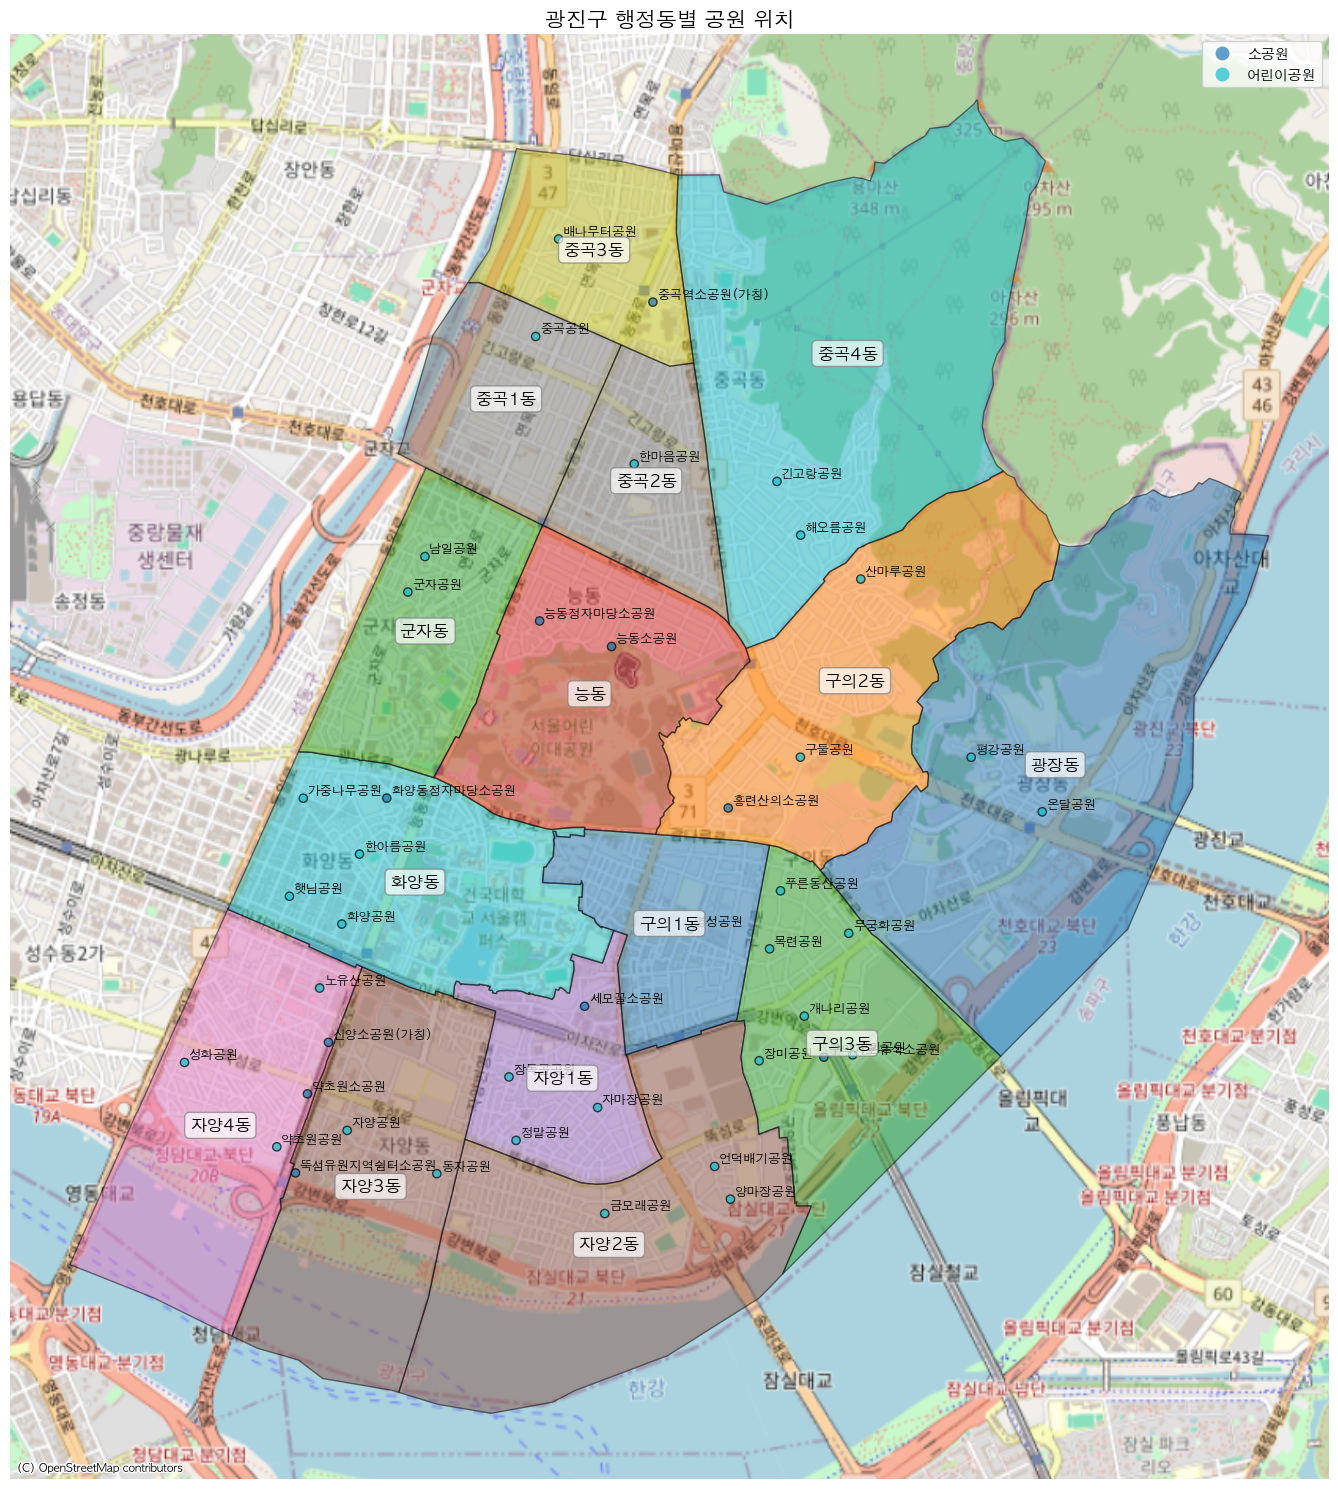

In [5]:
import geopandas as gpd
from shapely.geometry import Point
import contextily as ctx

# 1. 전국 행정동 경계 shp 파일 로드
shp_file = 'data/통계청_SGIS 행정구역 통계 및 경계_20240630/2. 경계/3. 2024년 2분기 기준 행정동 경계/bnd_dong_00_2024_2Q.shp'
korea_districts = gpd.read_file(shp_file)

# 2. 광진구 행정동만 필터링 (ADM_CD가 111050으로 시작하는 행)
# ADM_CD를 문자열로 변환하여 광진구 코드로 시작하는지 확인
korea_districts['ADM_CD'] = korea_districts['ADM_CD'].astype(str)
gwangjin_districts = korea_districts[korea_districts['ADM_CD'].str.startswith('11050')]

print(f"광진구 행정동 수: {len(gwangjin_districts)}")
print(gwangjin_districts[['ADM_NM', 'ADM_CD']])

# 3. 공원 데이터를 GeoDataFrame으로 변환
geometry = [Point(xy) for xy in zip(park_data['경도'], park_data['위도'])]
park_gdf = gpd.GeoDataFrame(park_data, geometry=geometry, crs="EPSG:4326")

# 4. 좌표계 통일
if gwangjin_districts.crs != park_gdf.crs:
    gwangjin_districts = gwangjin_districts.to_crs(park_gdf.crs)

# 5. 시각화
fig, ax = plt.subplots(figsize=(15, 15))

# 행정동 경계 그리기 - 다른 색상으로 구분
gwangjin_districts.plot(ax=ax, alpha=0.5, edgecolor='black', column='ADM_NM', legend=True, categorical=True)

# 공원 종류별로 다른 색상 사용
park_gdf.plot(ax=ax,
              column='공원구분', legend=True, 
              categorical=True, marker='o',
              alpha=0.7, edgecolor='black')

# 공원 이름 표시 
for idx, row in park_gdf.iterrows():
    ax.annotate(row['공원명'], 
                xy=(row.geometry.x, row.geometry.y),
                xytext=(3, 3),
                textcoords="offset points",
                fontsize=9)

# 행정동 이름 표시
for idx, row in gwangjin_districts.iterrows():
    centroid = row.geometry.centroid
    ax.annotate(row['ADM_NM'],
                xy=(centroid.x, centroid.y),
                ha='center', va='center',
                fontsize=12, fontweight='bold',
                bbox=dict(boxstyle="round,pad=0.3", fc='white', ec='gray', alpha=0.7))

# 배경 지도 추가 (OSM)
try:
    ax.set_axis_off()
    ctx.add_basemap(ax, crs=park_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
except Exception as e:
    print(f"배경 지도 추가 실패: {e}")

plt.title('광진구 행정동별 공원 위치', fontsize=15)
plt.tight_layout()
plt.show()

# 6. 공간 조인을 통해 각 공원이 속한 행정동 찾기
joined_parks = gpd.sjoin(park_gdf, gwangjin_districts, how="left", predicate="within")

In [6]:
# 행정동 이름을 원본 데이터에 추가
park_data['행정동'] = joined_parks['ADM_NM']
park_data.head(2)

,관리번호,공원명,공원구분,소재지도로명주소,소재지지번주소,위도,경도,공원면적,공원보유시설(운동시설),공원보유시설(유희시설),공원보유시설(편익시설),공원보유시설(교양시설),공원보유시설(기타시설),지정고시일,관리기관명,전화번호,데이터기준일자,행정동
0,11215-10510,성화공원,어린이공원,NaN,서울특별시 광진구 자양동 199-4,37.536207,127.061859,253.0,NaN,조합놀이대,NaN,NaN,NaN,1979-09-15,서울특별시 광진구청,02-450-7775,2025-03-10,자양4동
1,11215-10511,양마장공원,어린이공원,NaN,서울특별시 광진구 자양동 689-6,37.530871,127.088727,1113.0,NaN,"조합놀이대, 그네, 흔들놀이기구",NaN,NaN,NaN,1982-03-09,서울특별시 광진구청,02-450-7775,2025-03-10,자양2동


In [7]:
# 시설 다양성 점수 계산 (시설 유형의 수)
facility_columns = [col for col in park_data.columns if '공원보유시설' in col]

def count_facilities(row):
    count = 0
    for col in facility_columns:
        if pd.notna(row[col]) and row[col] != '':
            count += 1
    return count

park_data['시설다양성'] = park_data.apply(count_facilities, axis=1)

### 0.3 연령별 인구 데이터(age_data)를 행정동별로 취합하여 district_data에 연령별 비율을 추가

In [8]:
# 필수 보호자 동반 연령대
essential_care_cols = ['0~4세', '5~9세']
# 선택적 보호자 동반 연령대
optional_care_cols = ['10~14세']
# 보호자 연령대
caregiver_cols = ['30~34세', '35~39세', '40~44세', '45~49세']

# 청소년 비율
youth_cols = ['15~19세']
# 청년 비율
young_adult_cols = ['20~24세', '25~29세']
# 중장년 비율
middle_aged_cols = ['50~54세', '55~59세', '60~64세']
# 노인 비율
senior_cols = ['65~69세', '70~74세', '75~79세', '80~84세', '85~89세', '90~94세', '95~99세', '100세 이상']

def process_age_data(df):
    """연령별 인구 데이터 처리 (age_data)"""
    if df is None:
        return None
    
    # 복사본 생성
    df_copy = df.copy()
    
    # 모든 연령대 컬럼 데이터를 숫자로 변환
    age_cols = essential_care_cols + optional_care_cols + caregiver_cols + youth_cols + young_adult_cols + middle_aged_cols + senior_cols
    for col in age_cols:
        if col in df_copy.columns:
            df_copy[col] = pd.to_numeric(df_copy[col], errors='coerce')
    
    # 행정동 이름 확인
    # 첫 번째 열이 '행정동'으로 보임
    district_col = '행정동'
    # 결과 데이터프레임 초기화
    age_stats = pd.DataFrame()
    age_stats['행정동'] = df_copy['행정동']
    
    # 총 인구수 계산 (모든 연령대의 합)
    total_population = df_copy[age_cols].sum(axis=1)
    
    # 필수 보호자 동반 어린이 비율
    essential_child_pop = df_copy[essential_care_cols].sum(axis=1)
    age_stats['필수보호자동반비율'] = essential_child_pop / total_population
    
    # 선택적 보호자 동반 어린이 비율
    optional_child_pop = df_copy[optional_care_cols].sum(axis=1)
    age_stats['선택적보호자동반비율'] = optional_child_pop / total_population
    
    # 보호자 연령대 비율
    caregiver_pop = df_copy[caregiver_cols].sum(axis=1)
    age_stats['보호자비율'] = caregiver_pop / total_population

    # 청소년 비율
    youth_pop = df_copy[youth_cols].sum(axis=1)
    age_stats['청소년비율'] = youth_pop / total_population

    # 청년 비율
    young_adult_pop = df_copy[young_adult_cols].sum(axis=1)
    age_stats['청년비율'] = young_adult_pop / total_population

    # 중장년 비율
    middle_aged_pop = df_copy[middle_aged_cols].sum(axis=1)
    age_stats['중장년비율'] = middle_aged_pop / total_population

    # 노인 비율
    senior_pop = df_copy[senior_cols].sum(axis=1)
    age_stats['노인비율'] = senior_pop / total_population
    
    print("최종 age_stats:")
    print(age_stats.head())
    
    return age_stats

In [9]:
# 행정동 리스트 생성 (광진구 행정동 목록)
districts = [
    '중곡1동', '중곡2동', '중곡3동', '중곡4동', '능동', 
    '구의1동', '구의2동', '구의3동', '광장동', 
    '자양1동', '자양2동', '자양3동', '자양4동', '화양동', '군자동'
]

# 2. 기본 district_data 프레임 생성
district_data = pd.DataFrame({'행정동': districts})

# 기본 면적 데이터 추가
district_area = {
    '중곡1동': 0.62, '중곡2동': 0.55, '중곡3동': 0.60, '중곡4동': 2.32, '능동': 1.1, 
    '구의1동': 0.56, '구의2동': 1.39, '구의3동': 1.02, '광장동': 2.39, 
    '자양1동': 0.63, '자양2동': 0.63, '자양3동': 1.2, '자양4동': 1.16, '화양동': 1.1, '군자동': 0.73
}
district_data['면적_km2'] = district_data['행정동'].map(district_area)

In [10]:
district_data.columns

Index(['행정동', '면적_km2'], dtype='object')

## 1. 공원필요성(Park Need)과 공간접근성(Park Access) 간의 차이 계산

### 1.1 공간필요성(Park Need) 게산

In [7]:
# 표준화를 위한 스케일러 생성
scaler = MinMaxScaler()

# 필요성 관련 변수 표준화
need_features = ['인구밀도', '', '', '', ''] # 인구밀도에 가구수 반영..
district_data[need_features] = scaler.fit_transform(district_data[need_features])

# 가중치 적용하여 공간필요성 점수 계산
weights = {
    '인구밀도': 0.3,
    '아동비율': 0.3,
    '노인비율': 0.15,
    '저소득비율': 0.15,
    '임대주택비율': 0.1
}

district_data['공간필요성'] = sum(district_data[feature] * weight 
                             for feature, weight in weights.items())

# 100점 만점으로 변환
district_data['공간필요성'] = district_data['공간필요성'] * 100

### 1.2 공간접근성(Park Access) 계산

In [8]:
# 각 행정동별 공원 통계
district_parks = park_data.groupby('행정동').agg({
    '관리번호': 'count',
    '공원면적': 'sum',
    '시설다양성': 'mean'
}).rename(columns={'관리번호': '공원수'})

# 결과 데이터프레임에 병합
district_data = district_data.merge(district_parks, left_on='행정동', right_index=True, how='left')

# 결측치 처리 (공원이 없는 행정동)
district_data = district_data.fillna({'공원수': 0, '공원면적': 0, '시설다양성': 0})

# 근접성 점수 계산 (행정동 면적 대비 공원 면적 비율)
district_data['근접성'] = (district_data['공원면적'] / (district_data['면적_km2'] * 1000000)) * 100
district_data['근접성'] = district_data['근접성'].clip(upper=100)  # 최대 100점

# 품질 점수 계산 (시설 다양성 기반)
district_data['품질'] = district_data['시설다양성'] * 20  # 시설 유형이 5개이면 100점
district_data['품질'] = district_data['품질'].clip(upper=100)  # 최대 100점

# 종합 접근성 점수 계산 (근접성 70%, 품질 30%)
district_data['공간접근성'] = district_data['근접성'] * 0.7 + district_data['품질'] * 0.3


In [ ]:
# 공간필요성과 공간접근성 비교 분석
# 격차 계산
district_data['필요성_접근성_격차'] = district_data['공간필요성'] - district_data['공간접근성']

# 상태 분류
def classify_status(gap):
    if gap > 20:
        return '심각한 불균형'
    elif gap > 10:
        return '불균형'
    elif gap > 0:
        return '약간 불균형'
    elif gap > -10:
        return '적절'
    else:
        return '충분히 지원됨'

district_data['상태'] = district_data['필요성_접근성_격차'].apply(classify_status)

### 1.3 결과 출력

In [ ]:
# 결과 출력
print("\n== 행정동별 공원 필요성과 접근성 분석 결과 ==")
result_columns = ['행정동', '공간필요성', '공간접근성', '필요성_접근성_격차', '상태']
result_df = district_data[result_columns].sort_values('필요성_접근성_격차', ascending=False)
print(result_df)

In [ ]:
# 불균형 지역 확인
imbalanced = district_data[district_data['상태'].str.contains('불균형')]
print(f"\n불균형 지역 수: {len(imbalanced)} / {len(district_data)}")

# 심각한 불균형 지역
critical = district_data[district_data['상태'] == '심각한 불균형']
print(f"\n심각한 불균형 지역 수: {len(critical)}")
if len(critical) > 0:
    print(critical[result_columns])

In [ ]:
# 상관관계 분석
correlation = np.corrcoef(district_data['공간필요성'], district_data['공간접근성'])[0, 1]
print(f"\n공간필요성과 공간접근성의 상관계수: {correlation:.4f}")

# 시각화
plt.figure(figsize=(16, 12))

# 필요성과 접근성 비교
plt.subplot(2, 2, 1)
comparison_data = pd.melt(
    district_data[['행정동', '공간필요성', '공간접근성']],
    id_vars='행정동',
    value_vars=['공간필요성', '공간접근성']
)
ax = sns.barplot(x='행정동', y='value', hue='variable', data=comparison_data)
plt.title('행정동별 공원 필요성과 접근성 비교', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.ylabel('점수', fontsize=12)
plt.legend(title='', loc='upper right')

In [ ]:
# 격차 시각화
plt.subplot(2, 2, 2)
sorted_gap = district_data.sort_values('필요성_접근성_격차', ascending=False)
colors = {
    '심각한 불균형': 'red',
    '불균형': 'orange',
    '약간 불균형': 'yellow',
    '적절': 'green',
    '충분히 지원됨': 'blue'
}
bar_colors = [colors[status] for status in sorted_gap['상태']]
sns.barplot(x='행정동', y='필요성_접근성_격차', data=sorted_gap, palette=bar_colors)
plt.title('행정동별 필요성-접근성 격차', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
plt.ylabel('격차 점수', fontsize=12)

In [ ]:
# 산점도
plt.subplot(2, 2, 3)
sns.scatterplot(x='공간필요성', y='공간접근성', data=district_data, s=100)
for i, row in district_data.iterrows():
    plt.text(row['공간필요성']+0.5, row['공간접근성'], row['행정동'], fontsize=9)
plt.title(f'공간필요성과 접근성의 관계 (상관계수: {correlation:.4f})', fontsize=14)
plt.xlim(0, 100)
plt.ylim(0, 100)
plt.xlabel('공간필요성 점수', fontsize=12)
plt.ylabel('공간접근성 점수', fontsize=12)

# 행정동별 공원 수와 면적
plt.subplot(2, 2, 4)
ax1 = plt.gca()
ax2 = ax1.twinx()

# 막대 그래프: 공원 수
bars = sns.barplot(x='행정동', y='공원수', data=district_data, ax=ax1, color='skyblue')
ax1.set_ylabel('공원 수', color='blue', fontsize=12)
ax1.tick_params(axis='y', labelcolor='blue')

# 선 그래프: 공원 면적
sns.lineplot(x=range(len(district_data)), y='공원면적', data=district_data, 
             ax=ax2, marker='o', color='red', sort=False)
ax2.set_ylabel('공원 면적 (m²)', color='red', fontsize=12)
ax2.tick_params(axis='y', labelcolor='red')

plt.title('행정동별 공원 수와 면적', fontsize=14)
plt.xticks(range(len(district_data)), district_data['행정동'], rotation=45, ha='right')

plt.tight_layout()
plt.savefig('광진구_공원_필요성_접근성_분석.png', dpi=300)
# plt.show()